## 4-1. 들어가며


안녕하세요, 오늘은 시계열 예측(Time-Series Prediction)을 다루는 여러 가지 통계적 기법 중에 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average)에 대해 알아보고 이를 토대로 특정 주식 종목의 가격을 예측해 보는 실습을 진행해 보려고 합니다.

시계열 예측에 사용되는 모델에 ARIMA만 있는 것은 아닙니다. 페이스북에서 발표한 Prophet이라는 것도 있고, LSTM 등 딥러닝을 활용하는 방법도 있습니다. 하지만 ARIMA는 탄탄한 통계학 이론적 기반을 갖추고 있으며, 시계열 데이터를 이해하는 관점을 훈련하는 데에도 도움이 된다는 점에서 한 번쯤 다루어 볼 만한 주제라고 여겨집니다.

그럼 지금부터 시작해 보겠습니다.

### 학습 목표


- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

## 4-2. 시계열 예측이란(1) 미래를 예측한다는 것은 가능할까?

남들보다 미래의 정보를 단 한 시간 만이라도 먼저 알 수 있다면 어떨까요? 타임머신 같은 공상과학 영화 시나리오를 생각하지 않더라도, 분초 단위로 거래 가격이 변동하는 주식시장이나 외환 거래 시장에서 이런 능력이 얼마나 큰 수익을 가져다줄지는 자명합니다. 꼭 돈 버는 문제를 생각지 않더라도, 각종 산업현장에서 혹시 모를 위험을 미리 감지해서 대비할 수만 있다면 얼마나 유용할까요?


<br>

아래와 같은 미래 예측 시나리오를 생각해 봅시다.

- 지금까지의 주가 변화를 바탕으로 다음 주가 변동 예측
- 특정 지역의 기후데이터를 바탕으로 내일의 온도 변화 예측
- 공장 센터 데이터 변화 이력을 토대로 이상 발생 예측

위 예시의 공통점이 무엇일까요? 바로 예측의 근거가 되는 시계열(Time-Series) 데이터가 있다는 것입니다. 시계열이란 시간 순서대로 발생한 데이터의 수열이라는 뜻입니다. 굳이 간단한 수식의 형태를 빌리자면 아래와 같이 표현될 것입니다.

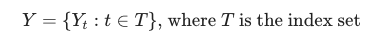

일정 시간 간격으로 발생한 데이터일 때가 많지만 꼭 그래야만 하는 것은 아닙니다. 매일의 주식 거래 가격을 __날짜-가격__ 형태로 날짜순으로 모아둔 데이터가 있다면 훌륭한 시계열 데이터가 될 것입니다. 이때 날짜가 __인덱스(index) 역할__을 하게 됩니다.

그렇다면 여기서 의문이 생깁니다. 특정 주식의 오늘까지의 매일 가격 변동 시계열 데이터가 수년 치 쌓여 있다고 칩시다. 그럼 우리는 이 데이터를 토대로 내일의 이 주식 가격이 얼마가 될지, 심지어 오를지 내릴지조차, 예측이 가능한 것일까요? 결론적으로 말하자면, 미래 예측은 불가능한 것입니다. 그럼에도 불구하고 미래의 데이터를 예측하려 든다면 적어도 다음 두 가지의 전제가 필요합니다.

1. 과거의 데이터에 일정한 패턴이 발견된다.
2. 과거의 패턴은 미래에도 동일하게 반복될 것이다.

=> __안정적(Stationary)__ 데이터에 대해서만 미래 예측이 가능하다.

In [1]:
! mkdir -p ~/aiffel/stock_prediction/data
! ln -s ~/data/* ~/aiffel/stock_prediction/data

ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/005930.KS.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/airline-passengers.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/daily-min-temperatures.csv': File exists


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

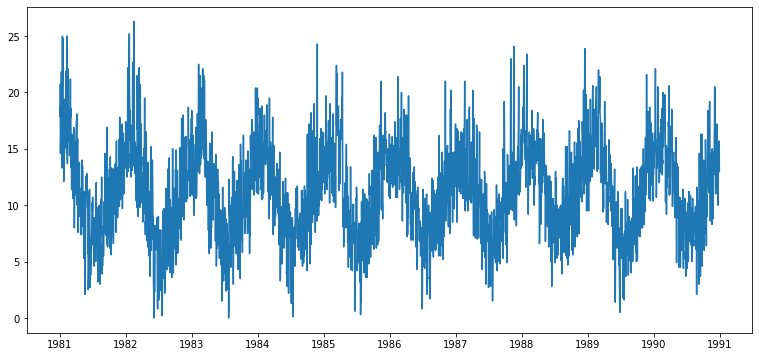

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

In [7]:
# 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.
ts1[ts1.isna()]  

Series([], Name: Temp, dtype: float64)

결측치가 있다면 2가지 방식으로 결측치를 처리할 수 있다.

1. 결측치가 있는 데이터를 모두 삭제(drop)
2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입

#### 결측치 보간 메서드


Series([], Name: Temp, dtype: float64)


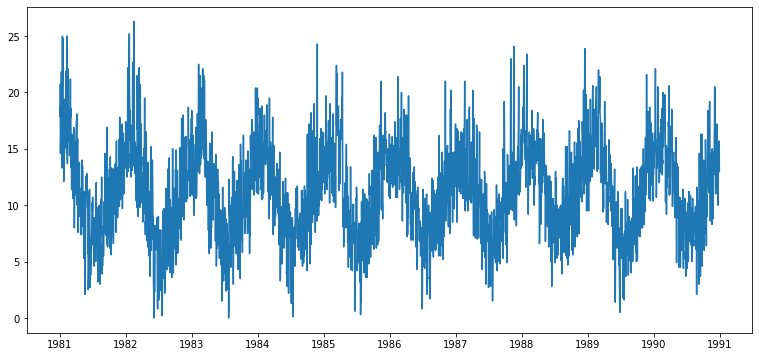

In [8]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

#### 시계열 데이터의 통계적 특성 확인하기 

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해보는 함수

현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이

- 구간의 평균(rolling mean, 이동평균)과
- 구간의 표준편차(rolling std, 이동표준편차)

를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것입니다.



> 아래 코드에서 window는 다음 정의에서 특정 개수(d)에 해당합니다.
> - 이동평균(Moving Average. 혹은 Rolling Mean)
>
> 이동평균이란 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 평균입니다.
>
>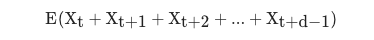
> - 이동표준편차(Rolling std)
> 
> 이동표준편차란 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 표준편차입니다. (표준편차는 분산에 제곱근을 씌운 값입니다.
>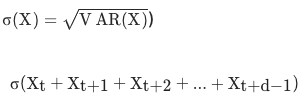

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

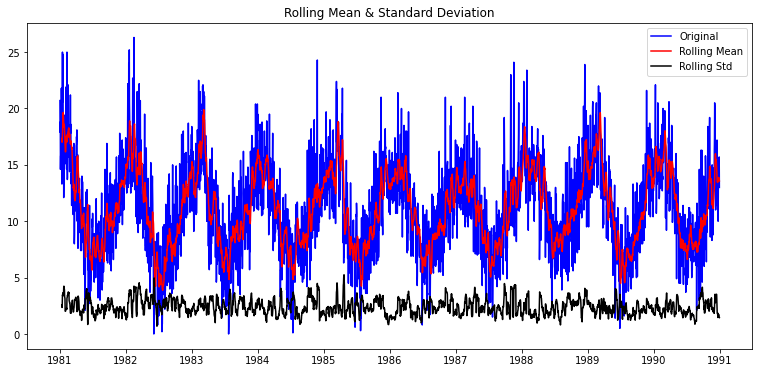

In [10]:
plot_rolling_statistics(ts1, window=12)

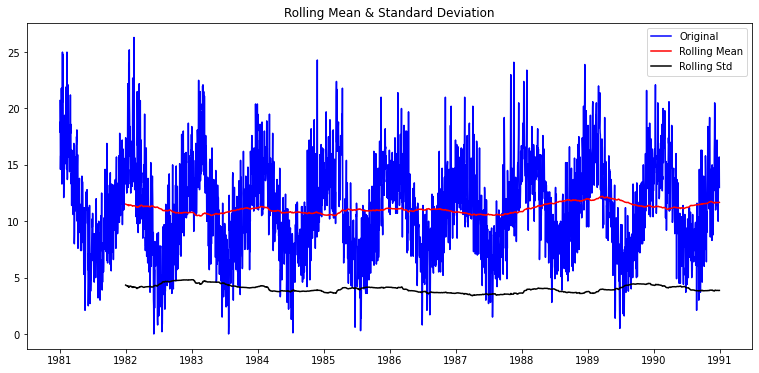

In [11]:
plot_rolling_statistics(ts1, window=365)

#### International airline passengers

시계열성이 덜 명확한 데이터셋 비교

In [12]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


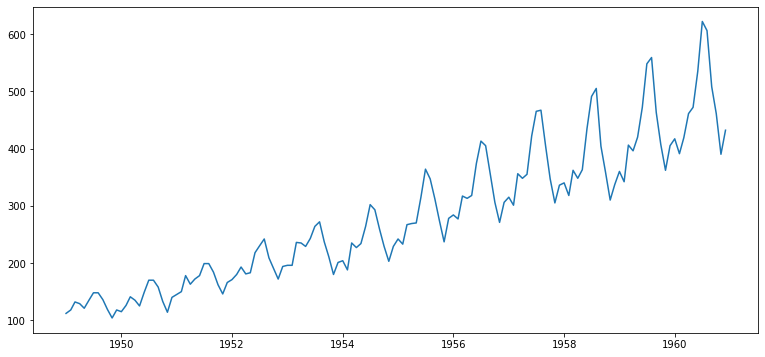

In [13]:
ts2 = df['Passengers']
plt.plot(ts2)

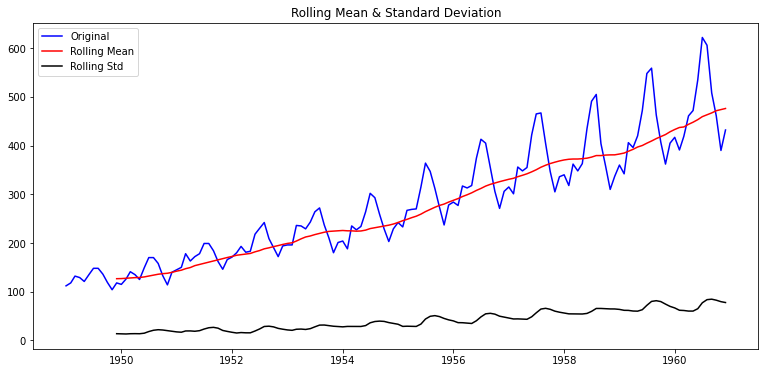

In [14]:
plot_rolling_statistics(ts2, window=12)

### Augmented Dickey-Fuller Test


이번 스텝에서는 Augmented Dickey-Fuller Test(ADF Test) 라는 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법을 소개하려고 합니다.

이 테스트는 다음과 같은 내용입니다.

> 1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
> 2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
> 3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다

#### 귀무가설, 대립가설, p-value 이란?

> 우리가 일반적으로 생각하는 가설은 아마 다음과 같을 수 있습니다. “지구는 둥글 것이다." 또는 “태양이 지구를 돌 것이다.” 하지만 통계적 가설 검정은 어떠한 큰 이론을 제안하는 가설이 아닙니다. 통계에서 가설은 우리가 알고 싶어 하는 “어떤 모집단의 모수(예: 평균, 분산, 등)에 대한 잠정적인 주장"입니다. 따라서 통계적 가설은 앞서 예를 든 가설들과는 다르게 일정한 형식을 따라야 합니다.
>
> 그 형식이 바로 “ 귀무가설(Null hypothesis:H0)” 과 “ 대립가설(Alternative hypothesis:H1)” 입니다. 통계적 가설 검정을 하려면 우선 두 가지 형식적 가설 (귀무가설 과 대립가설)을 설정해야 합니다. 그리고 어떤 가설을 채택할지를 확률적으로 따져보고 둘 중 하나를 채택합니다. 그러면 귀무가설은 무엇이고 대립가설은 무엇일까요?
>
> 귀무 가설은 통계학에서 처음부터 버릴 것을 예상하는 가설이다. 차이가 없거나 의미있는 차이가 없는 경우의 가설이며 이것이 맞거나 맞지 않다는 통계학적 증거를 통해 증명하려는 가설입니다. 쉽게 말하면 “모집단의 모수는 00와 같다.” 또는 “ 모집단의 모수는 00와 차이가 없다.” 라고 가정하는 것을 말합니다. 예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 귀무 가설은 “전국 남학생의 평균 키는 170cm과 같다.(또는 차이가 없다.)”가 될 것입니다. 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 귀무가설은 “개발한 백신은 효과가 없다.(또는 차이가 없다).” 가 됩니다. 즉 귀무가설은 “~와 차이가 없다.” “~의 효과가 없다.” “~와 같다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.
>
> 대립가설의 정의는 “귀무가설이 거짓이라면 대안적으로 참이 되는 가설" 입니다. 쉽게 설명하면 “귀무가설이 틀렸다고 판단했을 때(기각되었을 때), 대안적으로 선택하는(채택되는) 가설"을 말합니다. 다시 예로 설명드리면 대립가설은 “모집단의 모수는 00와 다르다.” 또는 “ 모집단의 모수는 00와 차이가 있다.” 라고 가정하는 것을 말합니다. 예를 들면 1) 만약 전국 남학생의 평균 키가 170cm라는 주장을 통계적으로 검정한다면, 이에 대한 대립 가설은 “전국 남학생의 평균 키는 170cm와 다르다.(또는 차이가 있다.)”가 될 것이고, 2)제약 회사에서 개발한 백신의 효과를 검정한다면, 대립가설은 “개발한 백신은 효과가 있다.(또는 차이가 있다).” 가 됩니다. 즉 대립가설은 “\~와 차이가 있다.” “\~의 효과는 있다.” “\~와 다르다.” 라는 형식으로 설정된다는 것을 알 수 있습니다.
>
> p-value 정의는 “귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치(예: 표본 평균)가 나타날 확률" 입니다. p값이 낮다는 것은 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 뜻합니다. 즉 p 값이 매우 낮으면, 이러한 표본 통계량은 우연히 나타나기 어려운 케이스이기 때문에, 우리는 귀무가설을 채택하지 않고(기각하고), 대안적인 가설, 즉 대립가설을 채택하게 됩니다.

이미 여기까지의 설명만으로도 머리가 굳어버리는 느낌을 받으실 수도 있을 것 같습니다. 시계열 분석은 탄탄한 통계학적 기반에 입각한 만큼 제대로 이해하기 위해서는 전문적인 훈련이 필요합니다.

그래서 ADF Test의 세부 알고리즘을 간단히 보고😉, statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 손쉽게 ADF Test의 결과를 이용할 것입니다. 🤗

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0

In [15]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


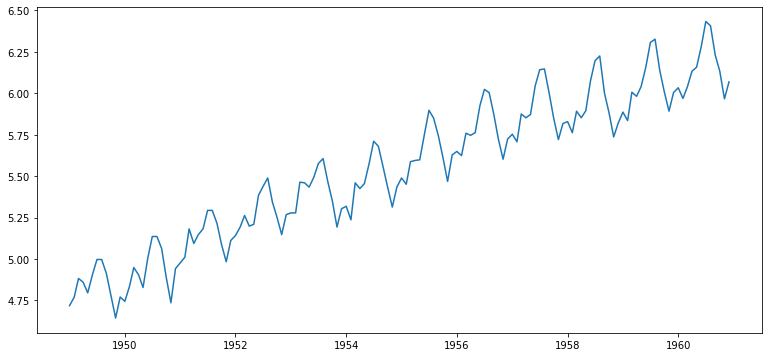

In [17]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [18]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


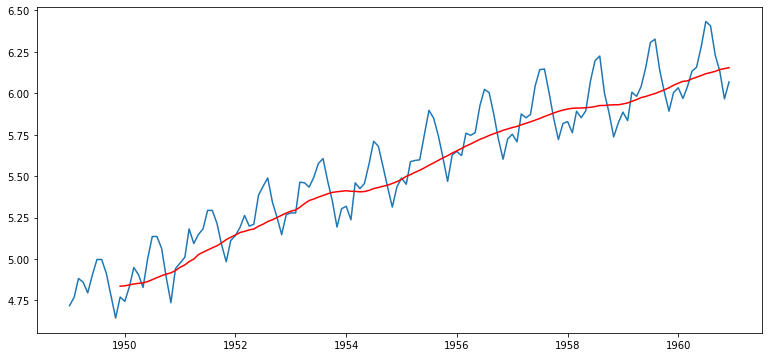

In [19]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [20]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [21]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

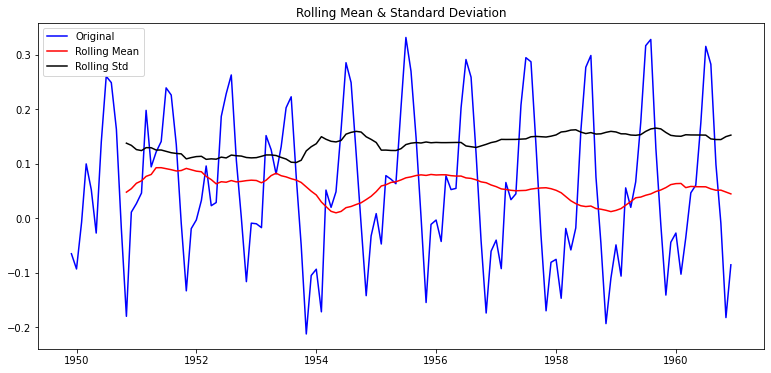

In [22]:
plot_rolling_statistics(ts_log_moving_avg)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


드디어 p-value가 0.02 수준이 되었습니다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

만약 위 코드에서 window=6을 적용하면 어떤 결과가 나올까요?

In [24]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)
print('슝=3')

슝=3


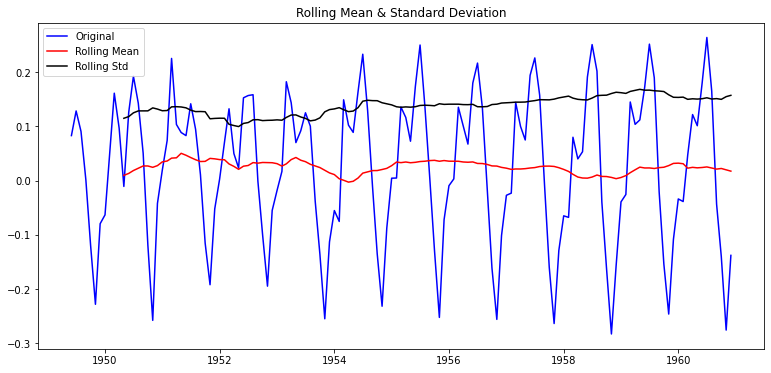

In [25]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [26]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


## 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기


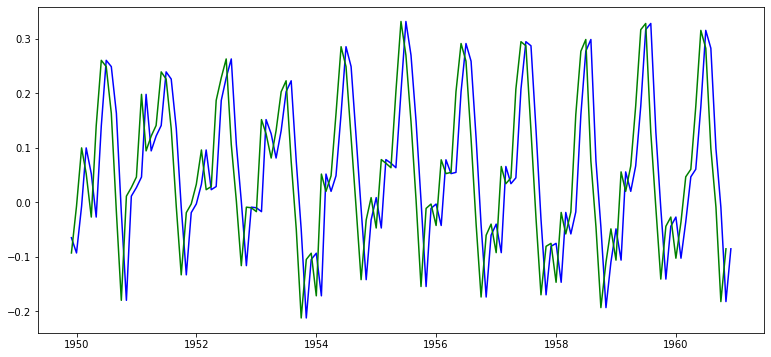

In [27]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

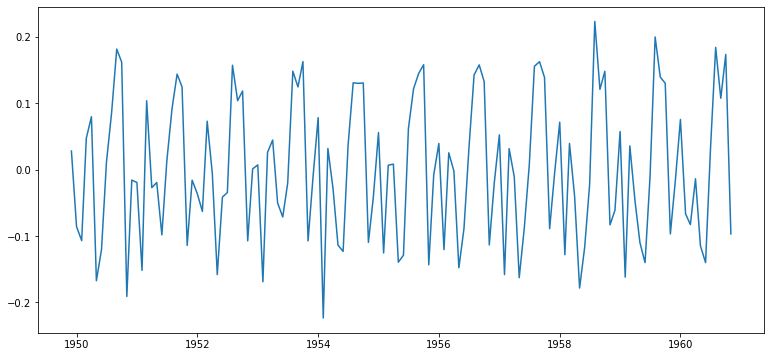

In [28]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## 2. 시계열 분해(Time series decomposition)

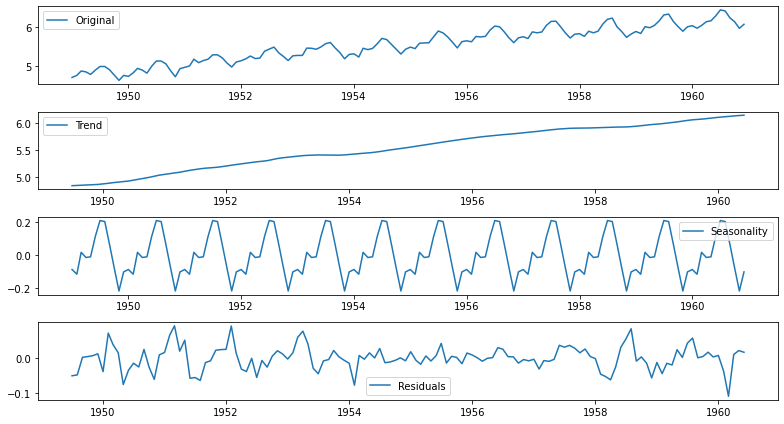

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

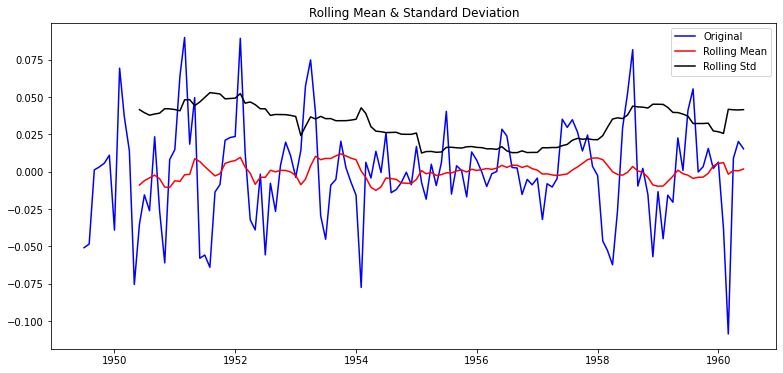

In [30]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


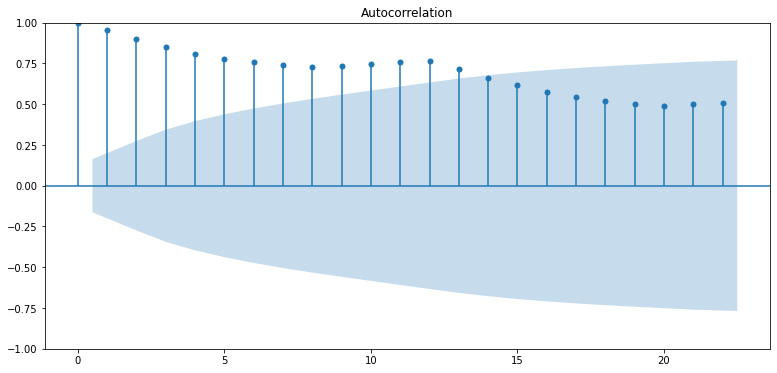

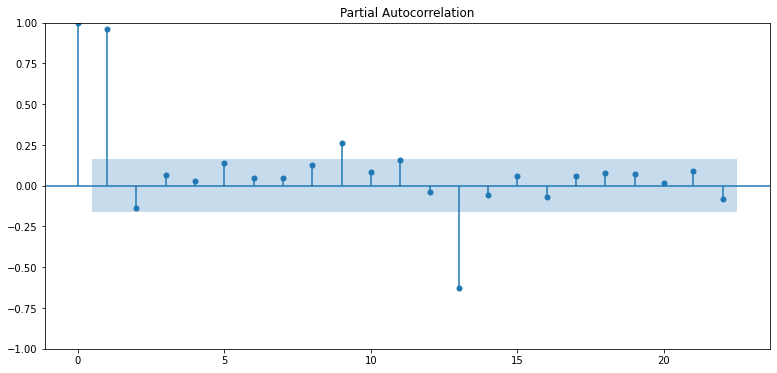

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


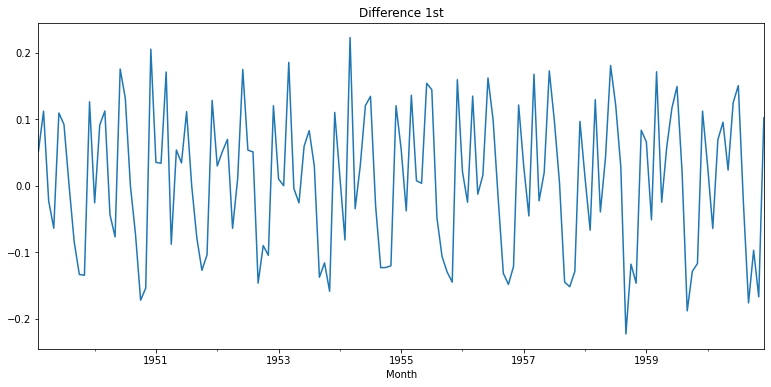

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


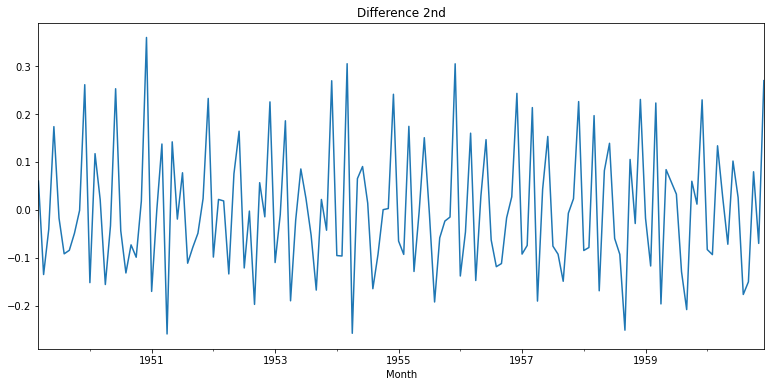

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 3. 학습 데이터 분리


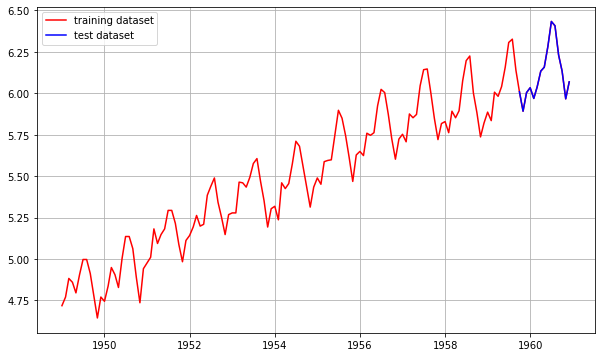

In [35]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [36]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## 4-8. ARIMA 모델 훈련과 추론

ARIMA 모델을 훈련하는 것은 아래와 같이 간단합니다.

In [37]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.942
Date:                Mon, 03 Apr 2023   AIC                           -409.883
Time:                        10:59:43   BIC                           -367.103
Sample:                    01-01-1949   HQIC                          -392.502
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2651      0.081     -3.277      0.001      -0.424      -0.107
ar.L2         -0.0044      0.108     -0.040      0.968      -0.216       0.208
ar.L3          0.0021      0.046      0.046      0.9

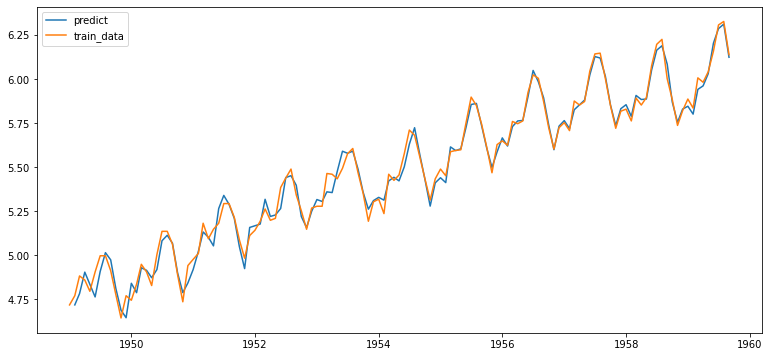

In [38]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

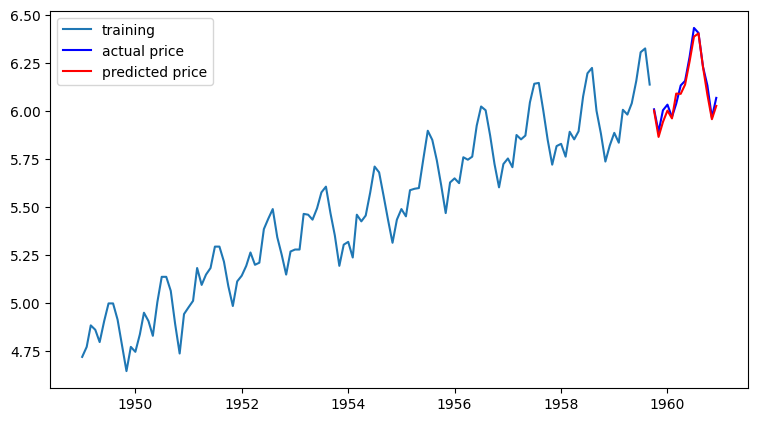

In [39]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  236.27939252509398
MAE:  12.55810531713422
RMSE:  15.371382258115045
MAPE: 2.76%


## 4-9. 프로젝트 : 주식 예측에 도전해 보자

In [41]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


STEP 1 : 시계열 데이터 준비

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [56]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


STEP 2 : 각종 전처리 수행

In [46]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [47]:
# 로그 변환 시도 
ts_log = np.log(ts)

STEP 3 : 시계열 안정성 분석
> - 정성적 그래프 분석
> - 정량적 Augmented Dicky-Fuller Test
> - 시계열 분해(Time Series Decomposition)
> - Residual 안정성 확인

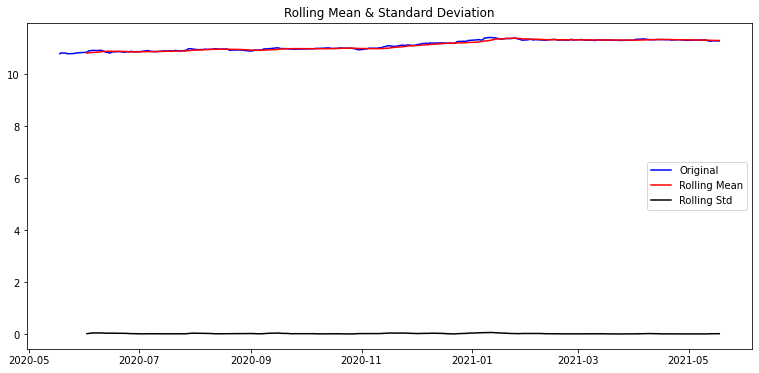

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


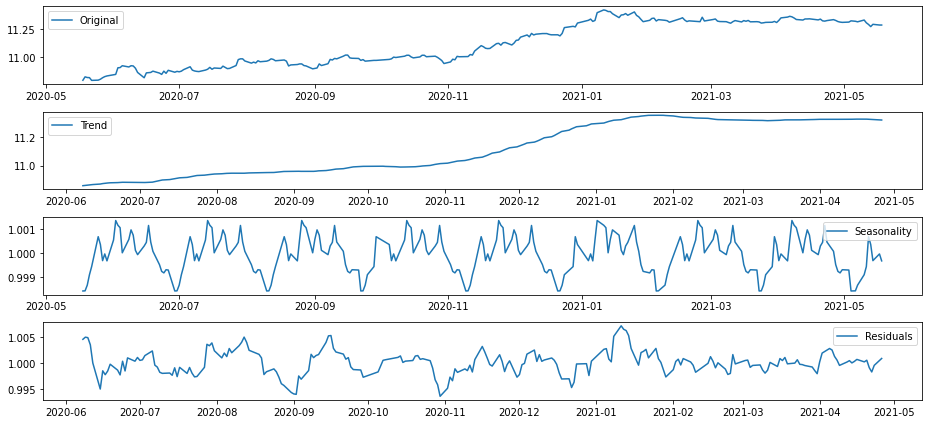

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

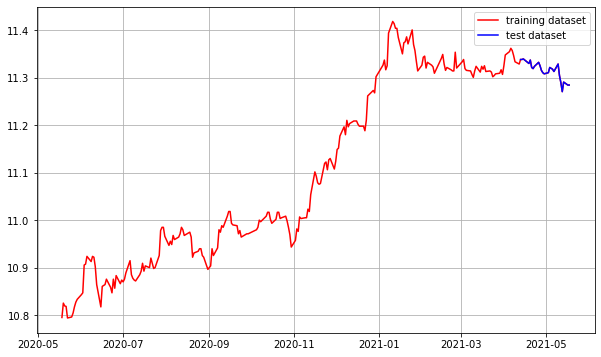

In [50]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기

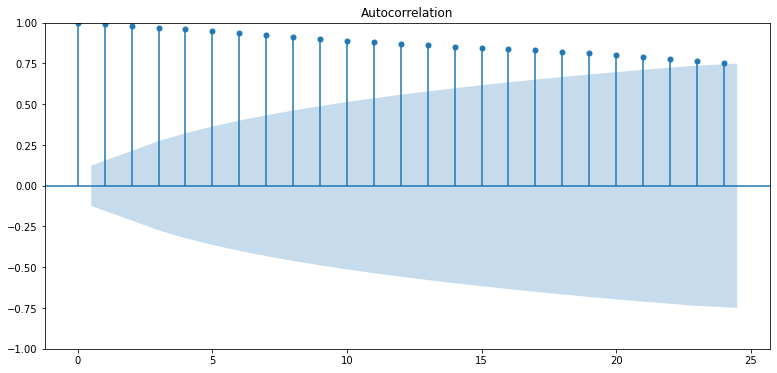

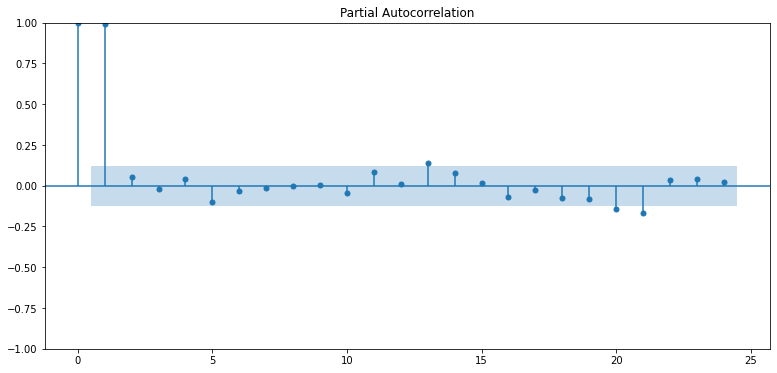

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


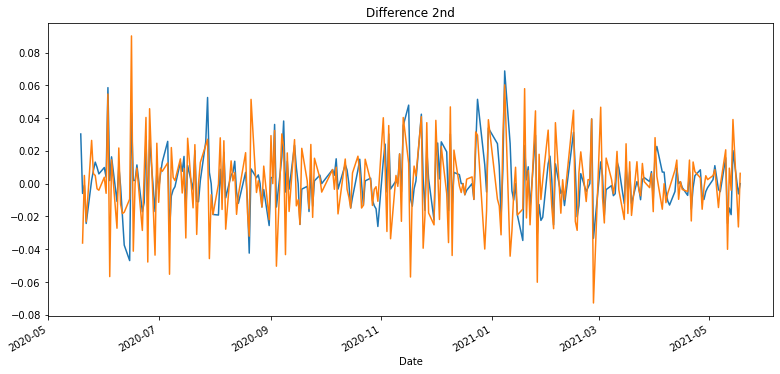

In [52]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP 6 : ARIMA 모델 훈련과 테스트

In [53]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 03 Apr 2023   AIC                          -1156.722
Time:                        11:05:34   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

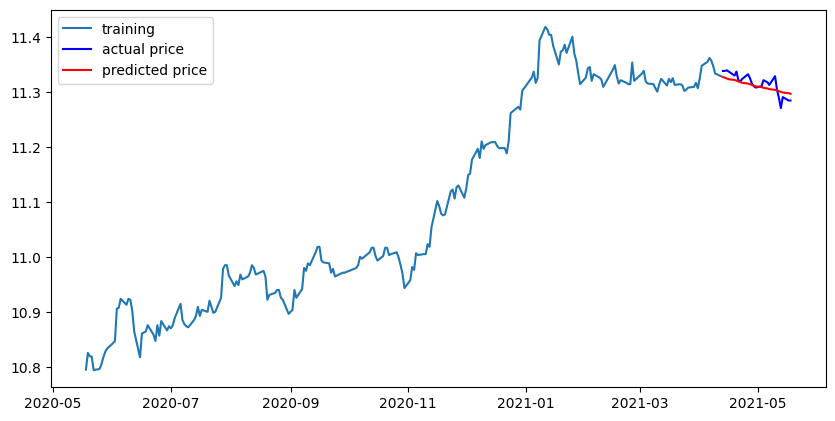

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


STEP 7 : 다른 주식 종목 예측해 보기


### TESLA Stock prediction

| 평가문항 | 상세기준 |
| -- | -- |
|1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

### 테슬라 주식 데이터 분석

어머니께서 최근에 테슬라 주식을 구매하셔서 동향을 예측해볼 예정입니다.

예제에 맞춰 종가를 기준으로 예측해보겠습니다.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/STOCK_US_XNAS_TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# 시계열 오름차순 정렬
df = df.sort_values('Date', ascending=True)
ts = df['Close']

ts.head()

Date
2022-03-31    359.20
2022-04-01    361.53
2022-04-04    381.82
2022-04-05    363.75
2022-04-06    348.59
Name: Close, dtype: float64

### 결측치 확인

interpolate를 통해 결측 시간대 및 결측행 확인

In [100]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 비정상성(Non-stationary)의 정상성(Stationary) 변환

- 목적: 정상성 확보를 통해 안정성 향상에 따른 예측력 개선

- 장점: 절약성 원칙(Principle of Pasimony, 파라미터를 적게 써도 됨)에 따라 적은 모수만으로 모델링 가능하기에 과적합 확률이 줄어듦
> - 비정상성 데이터는 범위가 무제한에 해당하고, 정상성 데이터는 범위를 제한해주기 때문에 예측이 더 쉬워지지만 무조건 정상성 변환이 필요한 것은 아님
> - 정상성 변화을 할 경우 모델이 단조로워지기 때문에 과적합 확률이 낮아짐
- 방법: 제곱, 루트, 로그, 차분 등



#### 1) 로그 변환

- 시간흐름에 비례하여 값이 커지는 경우(분산 증가)
- 비정상 확률 과정으로 표준편차가 자료의 크기에 비례하여 증가하거나 지수함수적으로 증가하는 경우
- 로그 변환한 확률 과정의 분산은 일정하기에 추세 제거로 기댓값이 0이 되면 정상 과정으로 모형화 가능

#### 2) 차분(Difference)

- 특정 시점 또는 시점들의 데이터가 발산할 경우, 시점간 차분(변화량)으로 정상성 변환 가능

In [115]:
# 로그 변환으로 정상성 변환 시도 
ts_log = np.log(ts)

#### 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인


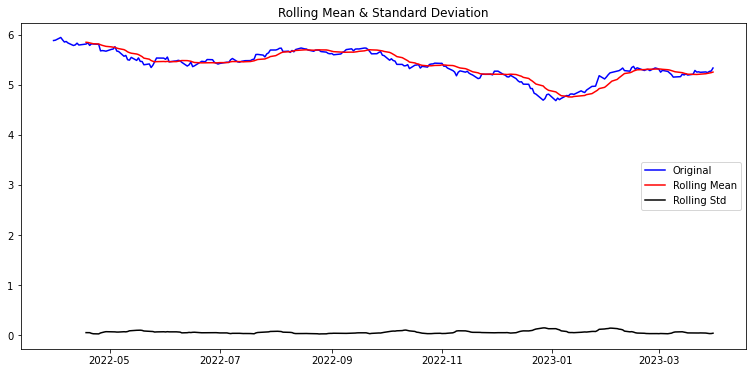

Results of Dickey-Fuller Test:
Test Statistic                  -2.232897
p-value                          0.194523
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


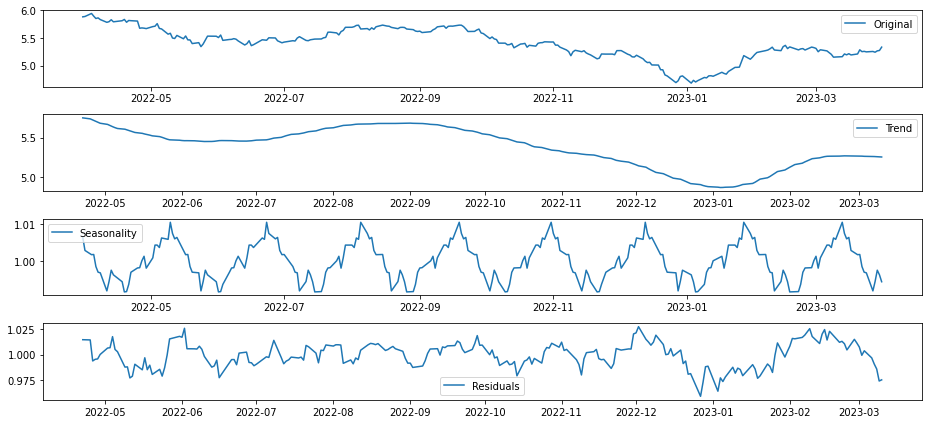

In [116]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [103]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.391409
p-value                          0.000307
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


### 학습, 테스트 데이터셋 생성

In [104]:
ts_log.sort_values('index', ascending=False)

Date
2022-04-04    5.944949
2022-04-05    5.896467
2022-04-01    5.890345
2022-03-31    5.883879
2022-04-07    5.864824
                ...   
2023-01-06    4.727919
2022-12-28    4.724818
2023-01-05    4.703567
2022-12-27    4.692265
2023-01-03    4.683057
Name: Close, Length: 252, dtype: float64

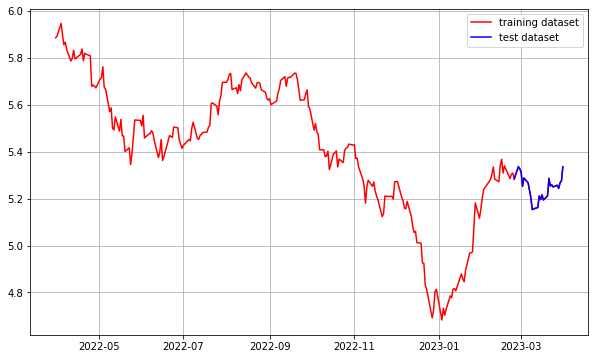

In [105]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

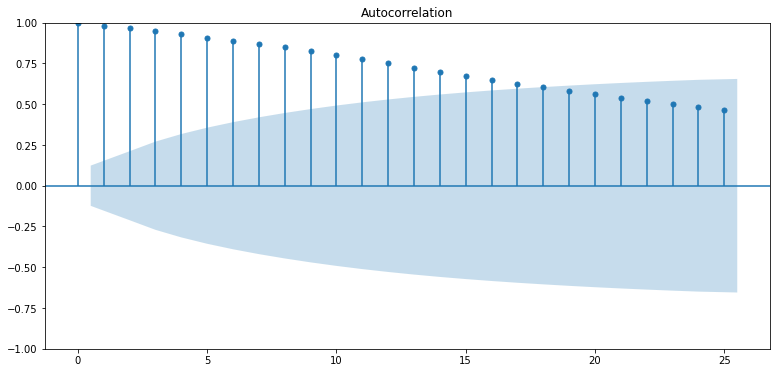

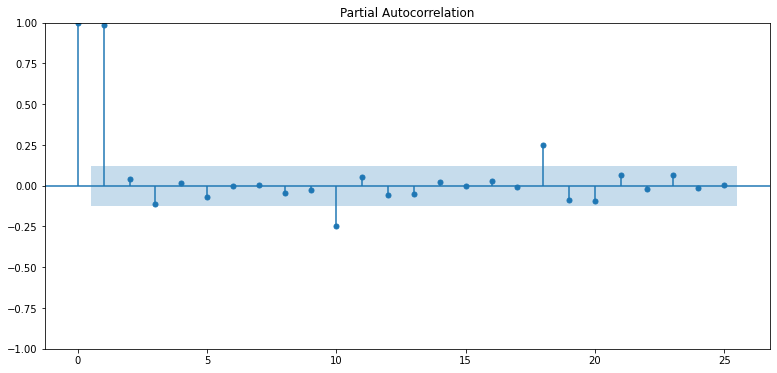

In [106]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.458154
p-value                          0.009129
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.115322e+01
p-value                        2.908551e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


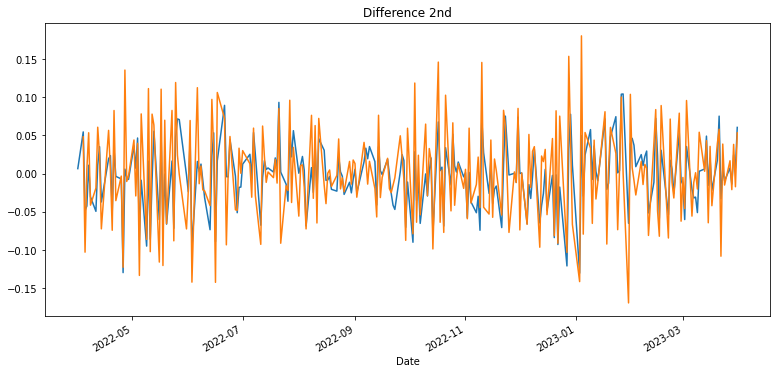

In [108]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### ARIMA 모델 훈련과 테스트

In [109]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 389.188
Date:                Mon, 03 Apr 2023   AIC                           -768.376
Time:                        13:25:22   BIC                           -751.273
Sample:                             0   HQIC                          -761.474
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5041      0.191     28.811      0.000       5.130       5.879
ar.L1          0.2897      0.336      0.862      0.388      -0.369       0.948
ar.L2          0.6943      0.328      2.115      0.0

ARIMA 모델 훈련결과 확인

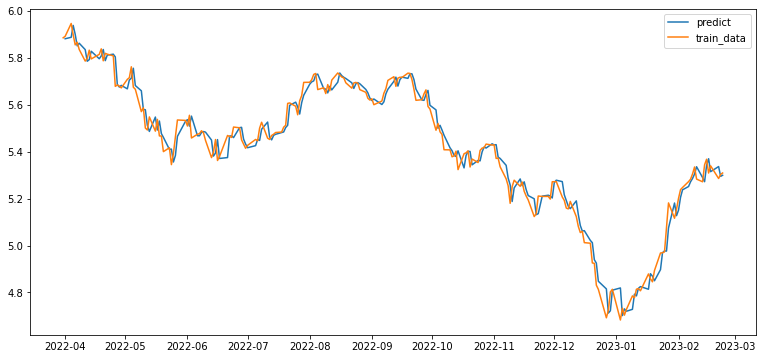

In [119]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

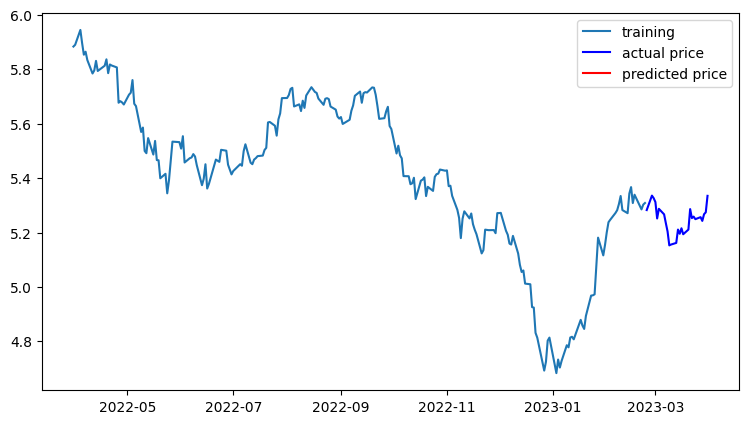

In [120]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

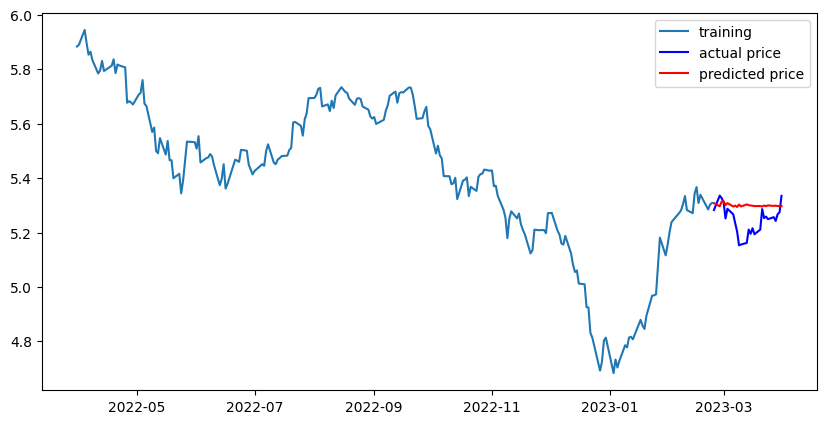

In [121]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

### MSE, MAE, RMSE, MAPE 값 확인

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  391.889929264488
MAE:  17.425551982644155
RMSE:  19.796209972226702
MAPE: 9.43%


최종적으로 에측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 9.43%의 오차율을 보임